In [ ]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
import requests
api = "apikey"
response = requests.get(api)
from time import sleep
from ta.volume import MFIIndicator, OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator, SMAIndicator, EMAIndicator, ADXIndicator, WMAIndicator, AroonIndicator, VortexIndicator
from ta.volatility import AverageTrueRange, BollingerBands
import optuna
import warnings
warnings.filterwarnings('ignore')

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#path to expiration_date file
df = pd.read_csv('expiration_date.csv') 
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))

In [3]:
# Low-pass filter dùng cho lọc nhiễu data
from scipy.signal import butter,lfilter 
def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [4]:
# Read data
data = response.json()["data"]
data = pd.DataFrame(data)
data['Date'] = pd.to_datetime(data['Date'])
data= data.sort_values(by='Date')
data=data.set_index('Date')
data=data.resample('15Min').agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume':'sum'}).dropna()
data.reset_index(inplace=True)

In [5]:
data

,Date,Open,High,Low,Close,Volume
0,2016-10-10 09:15:00,657.58,657.92,656.45,656.45,2041190
1,2016-10-10 09:30:00,656.27,656.27,653.48,654.12,2674920
2,2016-10-10 09:45:00,654.20,654.69,654.13,654.60,2754530
3,2016-10-10 10:00:00,654.54,656.49,654.47,656.49,3248400
4,2016-10-10 10:15:00,656.53,656.96,656.20,656.20,3769270
...,...,...,...,...,...,...
35905,2024-12-26 14:30:00,1341.71,1341.71,1341.71,1341.71,17500
35906,2024-12-26 14:45:00,1342.68,1342.68,1342.68,1342.68,14467000
35907,2024-12-27 09:15:00,1342.88,1347.84,1342.88,1346.75,12764270
35908,2024-12-27 09:30:00,1346.91,1347.73,1346.12,1346.69,11621404


In [6]:
def alpha(data, params):
    data['Close_filtered'] = pd.Series(lowpass_filter(data['Close'], params['t1']))#0.75. dùng lowpass_filter để lọc bớt nhiễu
    #tính chỉ báo
    data['MFI'] = MFIIndicator(high=data['High'], low=data['Low'], close=data['Close_filtered'], volume=data['Volume'], window=params['w1']).money_flow_index()#.w2: của sổ của chỉ báo
    data['RSI'] = RSIIndicator(close=data['Close_filtered'], window =params['w1']).rsi()#.w1: của sổ của chỉ báo
    data['MACD'] = MACD(data['Close'], window_slow=params['macd_slow'], window_fast=params['macd_fast'], window_sign=params['macd_sign']).macd()
    data['MACD_signal'] = MACD(data['Close'], window_slow=params['macd_slow'], window_fast=params['macd_fast'], window_sign=params['macd_sign']).macd_signal()
    bb = BollingerBands(close=data['Close_filtered'], window=params['bb_window'], window_dev=params['bb_dev'])
    data['BB_upper'] = bb.bollinger_hband()
    data['BB_lower'] = bb.bollinger_lband()
    data['BB_middle'] = bb.bollinger_mavg()
    #
    pos = 0
    position = []
    for i in range(len(data)):
        #
        RSI = data['RSI'].values[i]
        MFI= data['MFI'].values[i]
        MACDs = data['MACD'].values[i] 
        MACD_Signal =data['MACD_signal'].values[i]
        Close = data['Close_filtered'].values[i]
        BB_upper = data['BB_upper'].values[i]
        BB_lower = data['BB_lower'].values[i]
        BB_middle = data['BB_middle'].values[i]
        #
        if pos == 0:
            #điều kiện enter short
            if MFI < params['t2'] and RSI < params['t2_1'] and MACDs < MACD_Signal and Close < BB_upper:#13. threshold to enter short
                pos = -1
            #điều kiện vào long
            if MFI>params['t3'] and RSI > params['t3_1'] and MACDs >= MACD_Signal and Close > BB_lower:#81. threshold to enter long
                pos = 1
        elif pos == -1:
            #thoát short
            if MFI>params['t4'] or RSI > params['t4_1'] or MACDs >= MACD_Signal or Close > BB_middle:#59. threshold to exit short
                pos = 0
        else:
            #thoát long
            if MFI<params['t5'] or RSI < params['t5_1'] or MACDs < MACD_Signal or Close < BB_middle :#37. threshold to exit long
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            #thoát short cuối ngày(CÓ THỂ HOẶC KHÔNG)
            if pos == - 1:
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                #reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)
    #mục đích cuối cùng vẫn là cột pos(position)
    data['pos'] = position
    return data
#CÁC ĐIỀU KIỆN CÓ TRÊN LÀ NHỮNG ĐIỀU KIỆN ĐƠN SƠ, ĐỂ CÓ 1 ALPHA TỐT, RESEARCH CẦN NGHIÊN CỨU VÀ ADD THÊM CÁC ĐIỀU KIỆN KHÁC

In [7]:
data_train = data[(data['Date'] >= '2020-01-01') & (data['Date'] < '2024-01-01')].reset_index(drop=True)

# Tạo tập test từ năm 2018 và 2019
data_val= data[(data['Date'] >= '2018-01-01') & (data['Date'] < '2020-01-01')].reset_index(drop=True)
data_2024 = data[(data['Date'] >= '2024-01-01')].reset_index(drop=True)        

In [8]:
import optuna
import operator
class EarlyStoppingCallback:
    """Early stopping callback for Optuna."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            raise ValueError(f"Invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Perform early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

def logging_callback(study: optuna.Study, frozen_trial: optuna.Trial) -> None:
    """Log information only when a new best value is found."""
    previous_best_value = study.user_attrs.get("previous_best_value", None)

    # Log only if a new best value is found
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        best_trial = study.best_trial
        with open(param_file, "a") as f:
            f.write("New Best Trial Found:\n")
            f.write(f"Trial Number: {best_trial.number}\n")
            f.write(f"Params: {best_trial.params}\n")
            f.write(f"Value: {best_trial.value}\n")
            f.write("=" * 50 + "\n")


# Path to log file
param_file = "C:/Users/admin/Downloads/To_Bao_Chau/params/Alpha4.txt"

In [9]:
def objective(trial):
    params = {
        't1': trial.suggest_uniform('t1', 0.1, 1.0),
        'w1': trial.suggest_int('w1', 5, 40),
        't2': trial.suggest_int('t2', 10, 30),
        't2_1': trial.suggest_int('t2_1', 10, 30),
        't3': trial.suggest_int('t3', 70, 90),
        't3_1': trial.suggest_int('t3_1', 70, 90),
        't4': trial.suggest_int('t4', 40, 70),
        't4_1': trial.suggest_int('t4_1', 40, 70),
        't5': trial.suggest_int('t5', 10, 40),
        't5_1': trial.suggest_int('t5_1', 10, 40),
        'macd_slow': trial.suggest_int('macd_slow', 20, 40),
        'macd_fast': trial.suggest_int('macd_fast', 5, 20),
        'macd_sign': trial.suggest_int('macd_sign', 5, 25),
        'bb_window': trial.suggest_int('bb_window', 10, 50),  # Look-back period for Bollinger Bands
        'bb_dev': trial.suggest_uniform('bb_dev', 1.0, 3.0),  # Standard deviations for band width

        
    }
    try:
        ds = alpha(data, params)
        backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
        sharp = backtestInfo.Sharp()
        sharp_after_fee = backtestInfo.Sharp_after_fee()
        hitrate = backtestInfo.Hitrate()
        return_ = backtestInfo.Return()
        profit= backtestInfo.Profit_per_year()
        f1_score = (3*hitrate*return_*(sharp/10))/(sharp + hitrate+return_)
        print(sharp, sharp_after_fee, hitrate, return_)
        return f1_score
    except:
        return 0

In [ ]:
study = optuna.create_study(direction="maximize")

# Instantiate early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_rounds=500, direction="maximize")

# Run optimization with callbacks
study.optimize(
    objective,
    n_trials=4000,
    callbacks=[early_stopping_callback, logging_callback])

In [17]:
best_params = study.best_params
print(best_params)
study.best_value

{'t1': 0.2632315173082898, 'w1': 7, 't2': 24, 't2_1': 27, 't3': 77, 't3_1': 74, 't4': 62, 't4_1': 46, 't5': 21, 't5_1': 21, 'macd_slow': 26, 'macd_fast': 12, 'macd_sign': 12, 'bb_window': 41, 'bb_dev': 2.8370568694983067}


0.029804815400248395

Margin: 13.23
MDD: 60.77 (3.87%)

   Total trading quantity: 770
         Profit per trade: 2.51
             Total Profit: 2342.4
         Profit after fee: 1933.6
 Trading quantity per day: 0.77
 Profit per day after fee: 1.93
                   Return: 0.31
          Profit per year: 484.06
                  HitRate: 0.47
          HitRate per day: 0.48


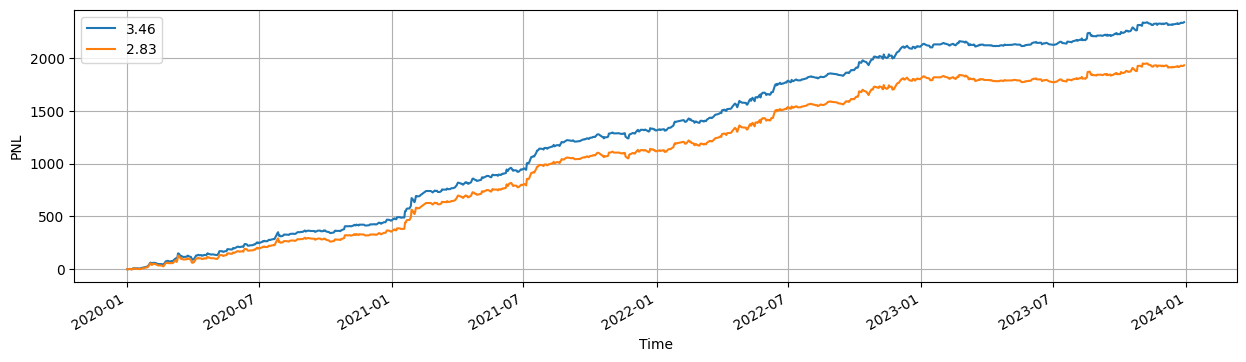

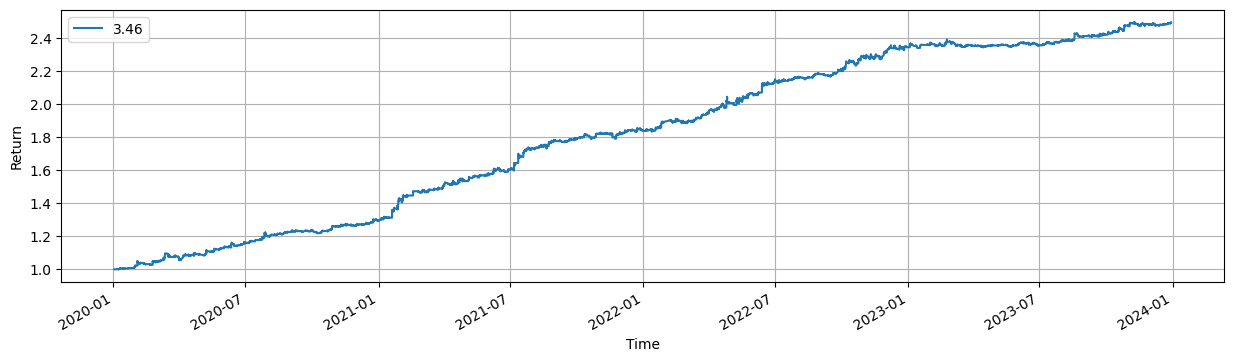

In [18]:
params = best_params
ds = alpha(data_train, params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
pnl = backtestInfo.Plot_PNL() 

Margin: 16.78
MDD: 34.7 (2.95%)

   Total trading quantity: 343
         Profit per trade: 2.63
             Total Profit: 1076.4
         Profit after fee: 902.6
 Trading quantity per day: 0.69
 Profit per day after fee: 1.81
                   Return: 0.38
          Profit per year: 451.92
                  HitRate: 0.52
          HitRate per day: 0.49


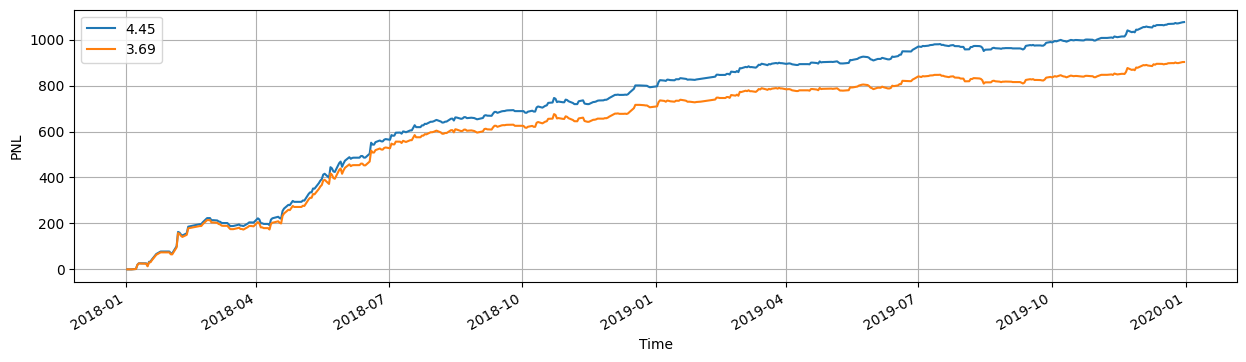

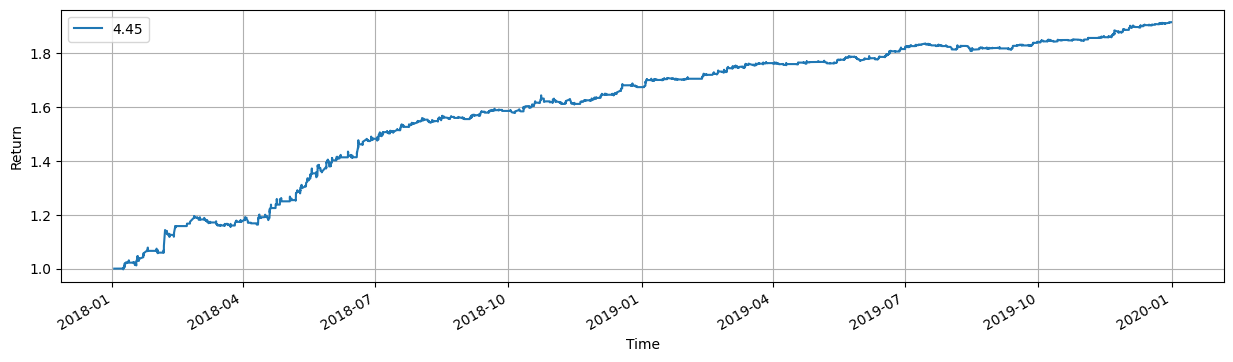

In [19]:
params = best_params
ds = alpha(data_val, params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
pnl = backtestInfo.Plot_PNL() 